### Imports

In [2]:
#imports
import os
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.linear_model as skl
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
import matplotlib 
matplotlib.rcParams['text.usetex']=True
import matplotlib.pyplot as plt
from sklearn.utils import resample
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPClassifier
#newer imports
from random import random, seed
from sklearn.linear_model import SGDRegressor
from matplotlib import cm
import seaborn as sns
from sklearn.metrics import accuracy_score



# Calculates value of Franke function
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

# Creates design matrix
def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

# Calculates R²-score
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

# Calculates mean squared error
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

def sigmoid(x):
    return 1/(1 + np.exp(-x))


# Feed-forward neural network

In [3]:
class NN:
    def __init__(
            self,
            X_data,
            Y_data,
            n_neurons=50,
            epochs=20,
            batch_size=10,
            eta=0.01, 
            lmbd=0.0, 
            n_categories = 1, 
            hidden_act_function = "sigmoid",
            last_act_function = "return input",
            gamma=0.0, 
            model="Regressor"):
        self.model = model
        
        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_neurons = n_neurons
        #self.model = model
        if (model == "Regressor"):
            self.n_categories = 1
        elif (model == "Classifier"): 
            self.n_categories = n_categories
        
        self.n_layers = len(self.n_neurons)
        if (hidden_act_function=="sigmoid"): 
            self.hl_act_function = self.sigmoid
            self.hl_act_f_der = self.sigmoid_derivative
        elif (hidden_act_function=="reLU"): 
            self.hl_act_function = self.reLU
            self.hl_act_f_der = self.reLU_derivative
        elif (hidden_act_function=="leakyReLU"): 
            self.hl_act_function = self.leaky_ReLU
            self.hl_act_f_der = self.leaky_ReLU_derivative
        else: 
            # Setting sigmoid to default activation function
            # in the hidden layers
            self.hl_act_function = self.sigmoid
        
        if (last_act_function=="return input"): 
            self.ll_act_function = self.return_input
        elif (last_act_function=="softmax"): 
            self.ll_act_function = self.softmax
        elif (last_act_function == "binary classifier"):
            self.ll_act_function = self.binary_classifier
        else: 
            # Setting return input as default last layer
            # activation function
            self.ll_act_function = self.return_input
        
        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd
        self.gamma = gamma
        
        print("MODEL: " + self.model)
        print("Hidden layer activation function: " + hidden_act_function) 
        print("Output layer activation function: " + last_act_function)
        print("X_data shape: ",  (X_data.shape))

        self.create_biases_and_weights()
    
    
    # Defining activation functions 
    # Hidden layer activation functions
    def sigmoid(self, x): 
        output = 1.0/(1.0+np.exp(-x))
        return output
    
    def sigmoid_derivative(self, x): 
        a = 1.0/(1.0+np.exp(-x))
        output = a*(1-a)
        return output
    
    def reLU(self, x): 
        x = np.maximum(0.0, x)
        return x
    
    def reLU_derivative(self, x): 
        x[x<=0] = 0
        x[x>0] = 1
        return x
    
    def leaky_ReLU(self, x):
        y1 = ((x>0)*x)
        y2 = ((x<=0)*x*0.01)
        return y1+y2
    
    def leaky_ReLU_derivative(self, x): 
        y1 = ((x>0)*1)
        y2 = ((x<=0)*0.01)
        return y1+y2
    
    # Last layer activation functions
    def softmax(self, x): 
        exp_term = np.exp(x)
        output = exp_term/np.sum(exp_term, axis=1, keepdims=True)
        return output
    
    def return_input(self, x):
        output = x
        return output
    
    def binary_classifier(self, x): 
        x[x<0.5] = 0
        x[x>=0.5] = 1
        return x

    def create_biases_and_weights(self):
        self.hidden_weights = []
        self.hidden_bias = []
        # In case of momentum SGD
        self.prev_grad_hidden_weights = []
        self.prev_grad_hidden_bias = []
        # First hidden layer
        weights, bias = self.add_layer(self.n_features, self.n_neurons[0])
        self.hidden_weights.append(weights)
        self.hidden_bias.append(bias)
        # Momentum SGD
        p_g_weights, p_g_bias = self.add_zero_layer(self.n_features, self.n_neurons[0])
        self.prev_grad_hidden_weights.append(p_g_weights)
        self.prev_grad_hidden_bias.append(p_g_bias)
        # 2nd-to next to last hidden layers
        for i in range(1, self.n_layers): 
            weights, bias = self.add_layer(self.n_neurons[i-1], self.n_neurons[i])
            self.hidden_weights.append(weights)
            self.hidden_bias.append(bias)
            # Momentum SGD
            prev_grad_weights, prev_grad_bias = self.add_zero_layer(self.n_neurons[i-1], self.n_neurons[i])
            self.prev_grad_hidden_weights.append(prev_grad_weights)
            self.prev_grad_hidden_bias.append(prev_grad_bias)
        # Output layer
        weights, bias = self.add_layer(self.n_neurons[-1], self.n_categories)
        self.output_weights = weights
        self.output_bias = bias
        # Momentum SGD
        prev_grad_weights, prev_grad_bias = self.add_zero_layer(self.n_neurons[-1], self.n_categories)
        self.prev_grad_output_weights = prev_grad_weights
        self.prev_grad_output_bias = prev_grad_bias
        
        
        
    def add_layer(self, n_l_1, n_l): 
        weights = np.random.randn(n_l_1, n_l) 
        bias = np.zeros(n_l) + 0.01
        return weights, bias
    def add_zero_layer(self, n_l_1, n_l): 
        weights = np.zeros((n_l_1, n_l))
        bias = np.zeros(n_l)
        return weights, bias

    def feed_forward(self):
        # feed-forward for training
        self.z_h = []
        self.a_h = []
        self.a_h_der = []
        # First layer
        z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
        a_h_temp = self.hl_act_function(z_h_temp)
        a_h_der_temp = self.hl_act_f_der(z_h_temp)
        self.z_h.append(z_h_temp)
        self.a_h.append(a_h_temp)
        self.a_h_der.append(a_h_der_temp)
        
        # Hidden layer
        for layer in range(1, self.n_layers): 
            z_h_temp = np.matmul(self.a_h[-1], self.hidden_weights[layer]) + self.hidden_bias[layer]
            a_h_temp = self.hl_act_function(z_h_temp)
            a_h_der_temp = self.hl_act_f_der(z_h_temp)
            self.z_h.append(z_h_temp)
            self.a_h.append(a_h_temp)
            self.a_h_der.append(a_h_der_temp)
            
        # ouput
        self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias
        self.a_o = self.ll_act_function(self.z_o)
       

    def feed_forward_out(self, X):
        # feed-forward for output
        z_h = np.matmul(X, self.hidden_weights[0]) + self.hidden_bias[0]
        a_h = self.hl_act_function(z_h)
        for layer in range(1, self.n_layers): 
            z_h = np.matmul(a_h, self.hidden_weights[layer]) + self.hidden_bias[layer]
            a_h = self.hl_act_function(z_h)

        z_o = np.matmul(a_h, self.output_weights) + self.output_bias
        a_o = self.ll_act_function(z_o)
        return a_o

    def backpropagation(self):
        error_output = self.a_o - self.Y_data
        error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h_der[-1]
        # Lists for storing gradients in hidden layers
        self.hidden_weights_gradients = []
        self.hidden_bias_gradients = []
        # Output weights and bias gradient
        #prev_grad = self.output_wei
        self.output_weights_gradient = np.matmul(self.a_h[-1].T, error_output)
        self.output_bias_gradient = np.sum(error_output, axis=0)
        # Looping through all layers
        for l in range(1, self.n_layers): 
            weights_g, bias_g = self.layer_gradient(self.a_h[self.n_layers-l-1].T, error_hidden)
            self.hidden_weights_gradients.append(weights_g)
            self.hidden_bias_gradients.append(bias_g)
            error_hidden = np.matmul(error_hidden, self.hidden_weights[self.n_layers-l].T)*self.a_h_der[self.n_layers-l-1]
        
        # Last layer
        hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
        hidden_bias_gradient = np.sum(error_hidden, axis=0)
        self.hidden_weights_gradients.append(hidden_weights_gradient)
        self.hidden_bias_gradients.append(hidden_bias_gradient)
        
        # Calculating new weights and biases
        if (self.lmbd > 0.0):
            self.regularization()
        
        
        if (self.gamma > 0.0): 
            # with momentum
            self.update_layers_momentum()
        else: 
            # without momentum
            self.update_layers()
        
    def layer_gradient(self, input_layer, error): 
        weights_gradient = np.matmul(input_layer, error)
        bias_gradient = np.sum(error, axis=0)
        return weights_gradient, bias_gradient
    
    def regularization(self): 
        self.output_weights_gradient -= self.lmbd*self.output_weights
        for layer in range(self.n_layers): 
            self.hidden_weights_gradients[layer] -= self.lmbd*self.hidden_weights[self.n_layers-1-layer]
        
    def update_layers(self): 
        self.output_weights -= self.eta*self.output_weights_gradient
        self.output_bias -= self.eta*self.output_bias_gradient
        for layer in range(self.n_layers): 
            self.hidden_weights[layer] -= self.eta * self.hidden_weights_gradients[self.n_layers-1-layer]
            self.hidden_bias[layer] -= self.eta*self.hidden_bias_gradients[self.n_layers-1-layer]
    
    def update_layers_momentum(self): 
        if (self.lmbd > 0.0): 
            self.regularization()
        # Updating previous gradient (with learning parameter and gamma)
        self.prev_grad_ouput_weights = self.add_momentum(self.prev_grad_output_weights, self.output_weights_gradient)
        self.prev_grad_ouput_bias = self.add_momentum(self.prev_grad_output_bias, self.output_weights_gradient)
        for layer in range(self.n_layers):
            self.prev_grad_hidden_weights[layer] = self.add_momentum(self.prev_grad_hidden_weights[layer], self.hidden_weights_gradients[self.n_layers-1-layer])
            self.prev_grad_hidden_bias[layer] = self.add_momentum(self.prev_grad_hidden_bias[layer], self.hidden_bias_gradients[self.n_layers-1-layer])
        
        # Updating weights and biases
        self.output_weights -= self.prev_grad_output_weights
        self.output_bias -= self.prev_grad_output_bias
        for layer in range(self.n_layers): 
            self.hidden_weights[layer] -= self.prev_grad_hidden_weights[layer]
            self.hidden_bias[layer] -= self.prev_grad_hidden_bias[layer]
            
            
        
    def add_momentum(self, prev_grad, gradient): 
        return self.gamma*prev_grad + self.eta*gradient
    
    def predict(self, X):
        if (self.model == "Regressor"):
            pred = self.feed_forward_out(X)
            return pred
        elif (self.model == "Classifier"):
            probabilities = self.feed_forward_out(X)
            return np.argmax(probabilities, axis=1)

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]
                
                
                self.iteration = j
                self.feed_forward()
                self.backpropagation()
        #if (self.model == "Classifier"): 
            #print("Classifier")
            
        #if (self.model == "Regressor"): 
            #print("Epoch {}".format(i))
            #print("MSE Train: ", MSE(self.Y_data, self.a_o))
            #print("R2 Train ", R2(self.Y_data, self.a_o))
         
        
            #print("Prediction: ", self.z_o)
            #print("Data: ", self.Y_data)

            
            

In [4]:
np.random.seed(0)

N = 40
degree = 20
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
mx, my = np.meshgrid(x, y)
z = FrankeFunction(mx, my) + 0.2*np.random.randn(N, N)
z = z.reshape(N*N, 1)
X = create_X(mx, my, degree)

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

X_train_mean = np.mean(X_train, axis=0); X_test_mean = np.mean(X_test, axis=0)
z_train_mean = np.mean(z_train, axis=0); z_test_mean = np.mean(z_test, axis=0)
X_train -= X_train_mean; X_test -= X_test_mean; z_train -= z_train_mean; z_test -= z_test_mean


dNN = NN(X_train,
         z_train,
         n_neurons=[100, 100, 100, 100, 100, 100, 100],
         epochs=20,
         batch_size=10,
         eta=0.01, 
         lmbd=0.0001, 
         n_categories = 1, 
         hidden_act_function = "sigmoid",
         gamma = 0.6, 
         last_act_function = "return input",
         model="Regressor")
dNN.train()
train_predict = dNN.predict(X_train)
test_predict = dNN.predict(X_test)
print("MSE train: ", MSE(train_predict, z_train))
print("R2 train: ", R2(train_predict, z_train))
print("MSE test: ", MSE(test_predict, z_test))
print("R2 test: ", R2(test_predict, z_test))

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
MSE train:  0.04379175203697167
R2 train:  0.3230893299502915
MSE test:  0.046474610222761115
R2 test:  0.2539558626697117


### Activation functions grid search

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  1e-07
Activation function =  sigmoid
R2 score on test set:  -85.7461857277459
R2 score on train set:  -75.07893616911291
MODEL: Regressor
Hidden layer activation function: reLU
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  1e-07
Activation function =  reLU
R2 score on test set:  -458.4434288828394
R2 score on train set:  -179.86116957777563
MODEL: Regressor
Hidden layer activation function: leakyReLU
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  1e-07
Activation function =  leakyReLU
R2 score on test set:  -266.66383977744357
R2 score on train set

<ipython-input-3-854ace93e973>:200: RuntimeWarning: overflow encountered in matmul
  error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h_der[-1]
<ipython-input-3-854ace93e973>:200: RuntimeWarning: invalid value encountered in multiply
  error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h_der[-1]
<ipython-input-3-854ace93e973>:206: RuntimeWarning: overflow encountered in matmul
  self.output_weights_gradient = np.matmul(self.a_h[-1].T, error_output)
<ipython-input-3-854ace93e973>:216: RuntimeWarning: invalid value encountered in matmul
  hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
<ipython-input-3-854ace93e973>:165: RuntimeWarning: invalid value encountered in matmul
  z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
<ipython-input-3-854ace93e973>:182: RuntimeWarning: overflow encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias


Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  0.01
Activation function =  reLU
R2 score on test set:  nan
R2 score on train set:  nan
MODEL: Regressor
Hidden layer activation function: leakyReLU
Output layer activation function: return input
X_data shape:  (1280, 231)


<ipython-input-3-854ace93e973>:206: RuntimeWarning: invalid value encountered in matmul
  self.output_weights_gradient = np.matmul(self.a_h[-1].T, error_output)
/Users/behnooshashrafi/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  0.01
Activation function =  leakyReLU
R2 score on test set:  nan
R2 score on train set:  nan
MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)


<ipython-input-3-854ace93e973>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-3-854ace93e973>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  0.1
Activation function =  sigmoid
R2 score on test set:  nan
R2 score on train set:  nan
MODEL: Regressor
Hidden layer activation function: reLU
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  0.1
Activation function =  reLU
R2 score on test set:  nan
R2 score on train set:  nan
MODEL: Regressor
Hidden layer activation function: leakyReLU
Output layer activation function: return input
X_data shape:  (1280, 231)


<ipython-input-3-854ace93e973>:182: RuntimeWarning: invalid value encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias


Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  0.1
Activation function =  leakyReLU
R2 score on test set:  nan
R2 score on train set:  nan


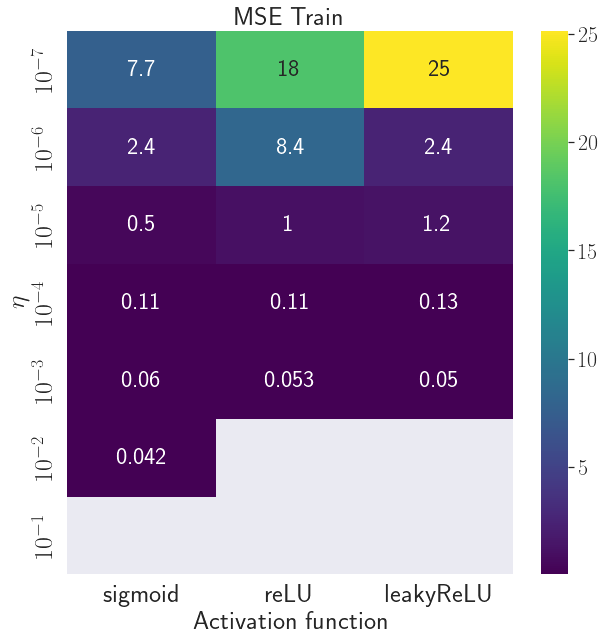

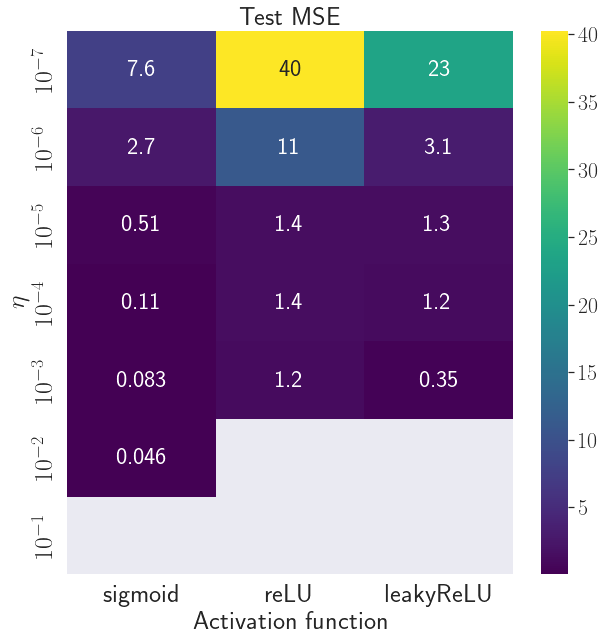

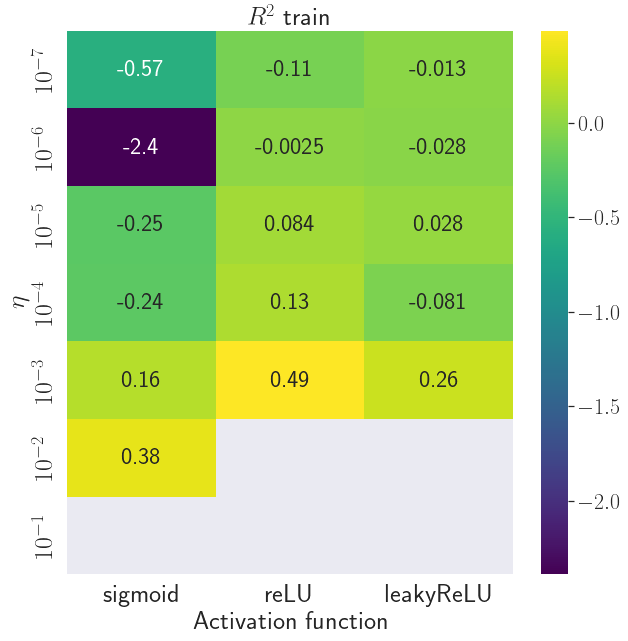

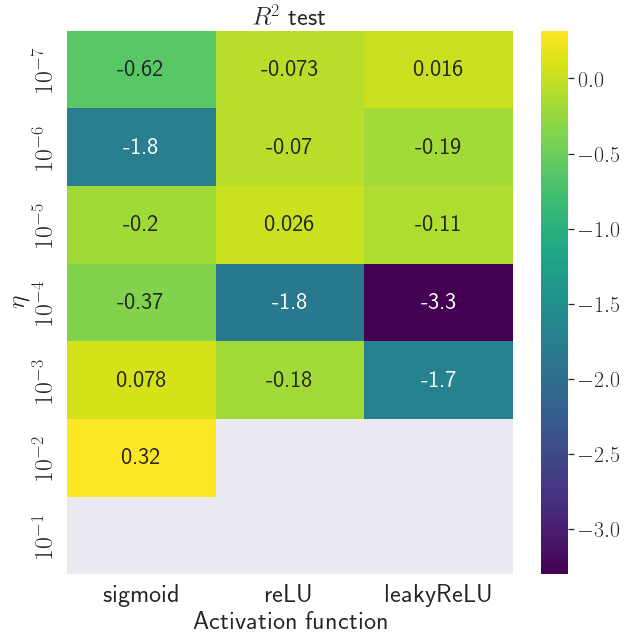

In [5]:
# TEST activation functions in hidden layers


act_functions = ["sigmoid", "reLU", "leakyReLU"]

eta_vals = np.logspace(-7, -1, 7)
lmbd_vals = np.logspace(-7, 0, 6)

tickseta_vals = []
for i in range(len(eta_vals)): 
    tickseta_vals.append(str(r'$10^{%.d}$'%(np.log10(eta_vals[i]))))
    
DNN_numpy = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
#DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
# grid search
for i, eta in enumerate(eta_vals):
    for j, function in enumerate(act_functions):
        dNN = NN(X_train,
                 z_train,
                 n_neurons=[100],
                 epochs=50,
                 batch_size=10,
                 eta=eta, 
                 lmbd=0.0001, 
                 n_categories = 1, 
                 hidden_act_function = function,
                 gamma = 0.0, 
                 last_act_function = "return input",
                 model="Regressor")
        #dNNscikit = MLPRegressor(hidden_layer_sizes=(100,100,), activation='logistic', solver='sgd', alpha=lmbd,
        #                       batch_size=10, learning_rate='constant', learning_rate_init=eta, random_state=1,
         #                      momentum=0.0)
        
        dNN.train()
        #dNNscikit.fit(X_train, z_train)
        
        DNN_numpy[i][j] = dNN
        #DNN_scikit[i][j] = dNNscikit
        
        test_predict = dNN.predict(X_test)
        train_predict = dNN.predict(X_train)
        
        print("Shape of test_predict: ", (test_predict.shape))
        print("Shape of train_predict: ", (train_predict.shape))
        
        print("Learning rate  = ", eta)
        print("Activation function = ", function)
        print("R2 score on test set: ", R2(z_test, test_predict))
        print("R2 score on train set: ", R2(z_train, train_predict))
        #print("Scikit R2 score on test set: ", dNNscikit.score(X_test, z_test))
        #print("Scikit R2 score on train set: ", dNNscikit.score(X_train, z_train))
        
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
import seaborn as sns
NORMAL = 26
sns.set(font_scale=2.0)

MSEtrain = np.zeros((len(eta_vals), len(act_functions)))
MSEtest = np.zeros((len(eta_vals), len(act_functions)))
R2train = np.zeros((len(eta_vals), len(act_functions)))
R2test = np.zeros((len(eta_vals), len(act_functions)))
#R2trainscikit = np.zeros((len(eta_vals), len(lmbd_vals)))
#R2testscikit = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(act_functions)):
        dNN = DNN_numpy[i][j]
        #dNNscikit = DNN_scikit[i][j]
        
        train_pred = dNN.predict(X_train) 
        test_pred = dNN.predict(X_test)
        
        MSEtrain[i][j] = MSE(train_pred, z_train)
        MSEtest[i][j] = MSE(test_pred, z_test)
        R2train[i][j] = R2(train_pred, z_train)
        R2test[i][j] = R2(test_pred, z_test)
        #R2trainscikit[i][j] = dNNscikit.score(X_train, z_train)
        #R2testscikit[i][j] = dNNscikit.score(X_test, z_test)
        
        

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(MSEtrain, annot=True, ax=ax, cmap="viridis", yticklabels=tickseta_vals, xticklabels=act_functions)
ax.set_title("MSE Train", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("Activation function", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_MSE_eta_act.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(MSEtest, annot=True, ax=ax, cmap="viridis", yticklabels=tickseta_vals, xticklabels=act_functions)
ax.set_title("Test MSE", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("Activation function", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_MSE_eta_act.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(R2train, annot=True, ax=ax, cmap="viridis", yticklabels=tickseta_vals, xticklabels=act_functions)
ax.set_title("$R^2$ train", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("Activation function", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_R2_eta_act.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(R2test, annot=True, ax=ax, cmap="viridis", yticklabels=tickseta_vals, xticklabels=act_functions)
ax.set_title("$R^2$ test", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("Activation function", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_R2_eta_act.pdf", format="pdf")
plt.show()

### eta and lambda grid search

In [30]:
np.random.seed(0)

eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)
# store the models for later use
tickseta_vals = []
tickslmbd_vals = []
for i in range(len(eta_vals)): 
    tickseta_vals.append(str(r'$10^{%.d}$'%(np.log10(eta_vals[i]))))
    tickslmbd_vals.append(str(r'$10^{%.d}$'%(np.log10(lmbd_vals[i]))))
        
DNN_numpy = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)


for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = NN(X_train, 
                 z_train,n_neurons=[10], 
                 epochs=5, 
                 batch_size=10, 
                 eta=eta, 
                 lmbd=lmbd, 
                 n_categories=1, 
                 hidden_act_function="sigmoid", 
                 gamma = 0.2, 
                 last_act_function="return input", 
                 model="Regressor")
        dnn.train()
        
        DNN_numpy[i][j] = dnn
        
        test_predict = dnn.predict(X_test)
        train_predict = dnn.predict(X_train)
        
        print("Shape of test_predict: ", (test_predict.shape))
        print("Shape of train_predict: ", (train_predict.shape))
        
        print("Learning rate  = ", eta)
        print("Lambda = ", lmbd)
        print("MSE train: ", MSE(train_predict, z_train))
        print("R2 train: ", R2(train_predict, z_train))
        print("MSE test: ", MSE(test_predict, z_test))
        print("R2 test: ", R2(test_predict, z_test))
        #print("Accuracy score on test set: ", accuracy_score(y_test, test_predict))
        #print("Accuracy score on train set: ", accuracy_score(y_train, train_predict))
        print()

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  1e-05
Lambda =  1e-05
MSE train:  0.3420376159594153
R2 train:  -0.7397648303664182
MSE test:  0.36071811735224985
R2 test:  -0.9469801468501167

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  1e-05
Lambda =  0.0001
MSE train:  0.627289078299121
R2 train:  -1.8769099096289699
MSE test:  0.6585414957823199
R2 test:  -1.2730101365855004

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  1e-05
Lambda =  0.001
MSE train:  10.589668168648142

<ipython-input-2-854ace93e973>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-2-854ace93e973>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  0.01
Lambda =  1e-05
MSE train:  0.08544098848409644
R2 train:  -1.9503500897395063
MSE test:  0.09534869704843871
R2 test:  -1.7430702774097484

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  0.01
Lambda =  0.0001
MSE train:  0.05398957732068928
R2 train:  0.21236432364344926
MSE test:  0.05851030871401654
R2 test:  0.1809110616207602

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  0.01
Lambda =  0.001
MSE train:  0.05987969407708432
R2 train:  -0.047625931649315945
MSE test:  0.0659635026442669
R2 test:  -0.16117339498146754

MODEL: Regressor
Hidden layer activa

<ipython-input-2-854ace93e973>:241: RuntimeWarning: overflow encountered in multiply
  self.hidden_weights_gradients[layer] -= self.lmbd*self.hidden_weights[self.n_layers-1-layer]
<ipython-input-2-854ace93e973>:241: RuntimeWarning: overflow encountered in subtract
  self.hidden_weights_gradients[layer] -= self.lmbd*self.hidden_weights[self.n_layers-1-layer]
<ipython-input-2-854ace93e973>:165: RuntimeWarning: invalid value encountered in matmul
  z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]


Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  1.0
Lambda =  1e-05
MSE train:  0.07593852063131726
R2 train:  -0.20015414063922354
MSE test:  0.0996714118910645
R2 test:  -0.5629700879267932

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  1.0
Lambda =  0.0001
MSE train:  0.048694432085515583
R2 train:  0.2143638875664181
MSE test:  0.05247873634961851
R2 test:  -0.0694891282098018

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  1.0
Lambda =  0.001
MSE train:  0.07375270316978703
R2 train:  0.3053131127054258
MSE test:  0.10072472898919879
R2 test:  0.3374995236757352

MODEL: Regressor
Hidden layer activation f

<ipython-input-2-854ace93e973>:264: RuntimeWarning: overflow encountered in subtract
  self.hidden_weights[layer] -= self.prev_grad_hidden_weights[layer]
<ipython-input-2-854ace93e973>:165: RuntimeWarning: overflow encountered in matmul
  z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
<ipython-input-2-854ace93e973>:270: RuntimeWarning: overflow encountered in add
  return self.gamma*prev_grad + self.eta*gradient


Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  1.0
Lambda =  10.0
MSE train:  nan
R2 train:  nan
MSE test:  nan
R2 test:  nan

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  10.0
Lambda =  1e-05
MSE train:  0.40938375067261246
R2 train:  -39.73179028083612
MSE test:  0.39058249615950436
R2 test:  -35.31475943729714

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  10.0
Lambda =  0.0001
MSE train:  0.17268970798116018
R2 train:  -0.520412843067692
MSE test:  1.2928789851994473
R2 test:  -0.333670277590141

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_

<ipython-input-2-854ace93e973>:270: RuntimeWarning: overflow encountered in multiply
  return self.gamma*prev_grad + self.eta*gradient


Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  10.0
Lambda =  1.0
MSE train:  nan
R2 train:  nan
MSE test:  nan
R2 test:  nan

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  10.0
Lambda =  10.0
MSE train:  nan
R2 train:  nan
MSE test:  nan
R2 test:  nan



<ipython-input-2-854ace93e973>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))


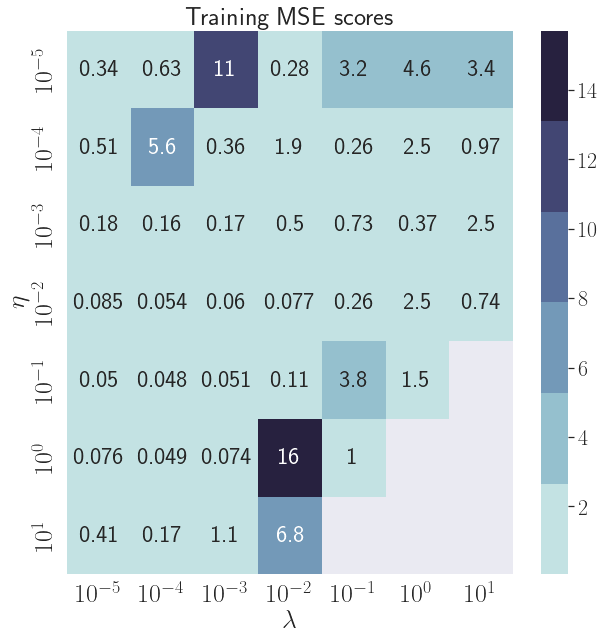

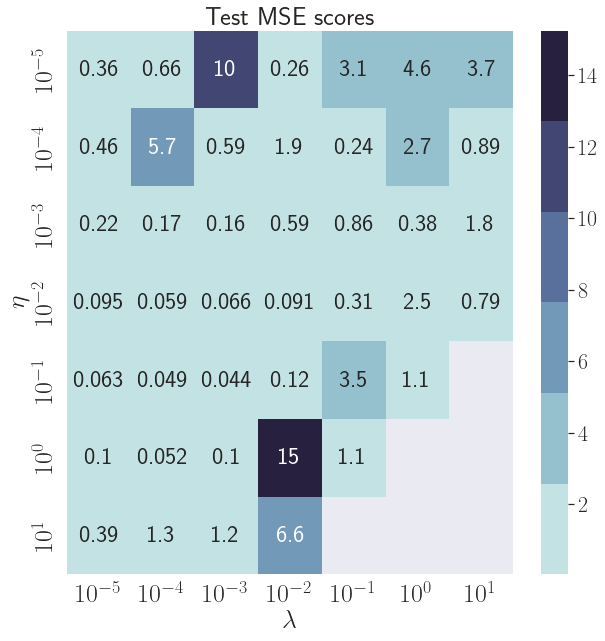

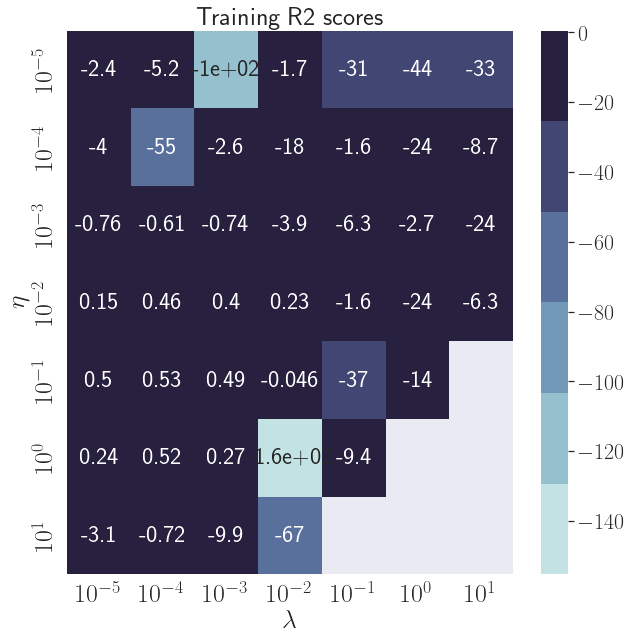

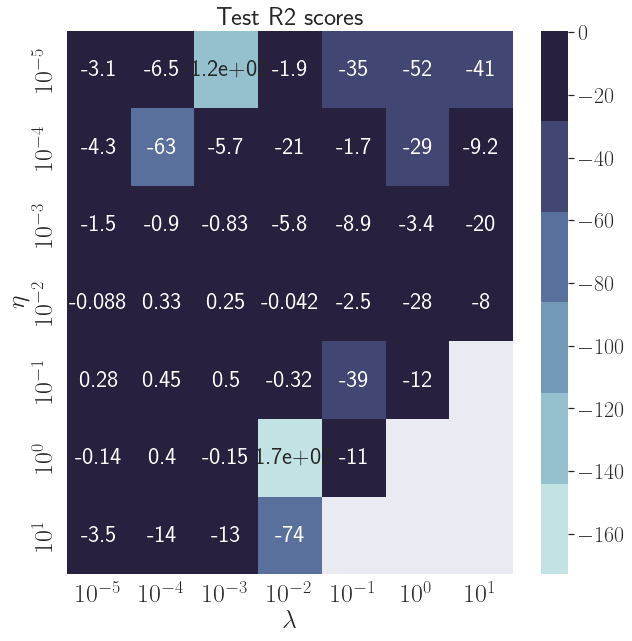

In [31]:
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
import seaborn as sns
NORMAL = 26
sns.set(font_scale=1.8)

train_MSE = np.zeros((len(eta_vals), len(lmbd_vals)))
test_MSE = np.zeros((len(eta_vals), len(lmbd_vals)))

train_R2 = np.zeros((len(eta_vals), len(lmbd_vals)))
test_R2 = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        dnn = DNN_numpy[i][j]
        
        train_pred = dnn.predict(X_train) 
        test_pred = dnn.predict(X_test)

        train_MSE[i][j] = MSE(z_train, train_pred)
        test_MSE[i][j] = MSE(z_test, test_pred)
        
        train_R2[i][j] = R2(z_train, train_pred)
        test_R2[i][j] = R2(z_test, test_pred)

NORMAL = 26
sns.set(font_scale=2.0)
 
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_MSE, annot=True, ax=ax, cmap=sns.color_palette("ch:start=.2,rot=-.3"), xticklabels = tickslmbd_vals, yticklabels = tickseta_vals)
ax.set_title("Training MSE scores", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("$\lambda$", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_MSE_score_eta_lmb.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_MSE, annot=True, ax=ax, cmap=sns.color_palette("ch:start=.2,rot=-.3"), xticklabels = tickslmbd_vals, yticklabels = tickseta_vals)
ax.set_title("Test MSE scores", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("$\lambda$", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_MSE_score_eta_lmb.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_R2, annot=True, ax=ax, cmap=sns.color_palette("ch:start=.2,rot=-.3"), xticklabels = tickslmbd_vals, yticklabels = tickseta_vals)
ax.set_title("Training R2 scores", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("$\lambda$", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_R2_score_eta_lmb.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_R2, annot=True, ax=ax, cmap=sns.color_palette("ch:start=.2,rot=-.3"), xticklabels = tickslmbd_vals, yticklabels = tickseta_vals)
ax.set_title("Test R2 scores", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("$\lambda$", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_R2_score_eta_lmb.pdf", format="pdf")
plt.show()


# fig, ax = plt.subplots(figsize = (10, 10))
# sns.heatmap(test_R2, annot=True, ax=ax, cmap="viridis", yticklabels=tickseta_vals, xticklabels=tickslmbd_vals)
# ax.set_title("Test R2 scores", fontsize=NORMAL)
# ax.set_ylabel("$\eta$", fontsize=NORMAL)
# ax.set_xlabel("$\lambda$", fontsize=NORMAL)
# ax.tick_params(labelsize=NORMAL)
# plt.savefig("test_R2_score_eta_lmb.pdf", format="pdf")
# plt.show()



### number of layer and number of neurons in each layer grid search

In [45]:
n_layers = [3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
n_neurons_vals = [10, 20, 50, 100, 150, 200]

# store the models for later use
DNN_numpy = np.zeros((len(n_layers), len(n_neurons_vals)), dtype=object)

# grid search
for i, n_layer in enumerate(n_layers):
    for j, neurons in enumerate(n_neurons_vals): 
        lneurons = [neurons for j in range(n_layer)]
        dnn = NN(X_train, 
                 z_train,
                 n_neurons=lneurons, 
                 epochs=5, 
                 batch_size=10, 
                 eta=0.01, 
                 lmbd=0.0001, 
                 n_categories=1, 
                 hidden_act_function="sigmoid", 
                 gamma = 0.2, 
                 last_act_function="return input", 
                 model="Regressor")
        dnn.train()
        
        DNN_numpy[i][j] = dnn
        
        test_predict = dnn.predict(X_test)
        train_predict = dnn.predict(X_train)
        
        print("Shape of test_predict: ", (test_predict.shape))
        print("Shape of train_predict: ", (train_predict.shape))
        
        print("Neurons: ", neurons)
        print("Layers: ", n_layer)
        print("MSE on test set: ", MSE(z_test, test_predict))
        print("MSE on train set: ", MSE(z_train, train_predict))
        print("R2 on test set: ", R2(z_test, test_predict))
        print("R2 on train set: ", R2(z_train, train_predict))
        print()
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow


MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Neurons:  10
Layers:  3
MSE on test set:  0.06555696104103567
MSE on train set:  0.06964380533357428
R2 on test set:  0.2520171095087791
R2 on train set:  0.3074399328489753

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Neurons:  20
Layers:  3
MSE on test set:  0.05778256563160271
MSE on train set:  0.05519418639980833
R2 on test set:  0.3407203480028477
R2 on train set:  0.4511315219450025

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Neurons:  50
Layers:  3
MSE on test set:  0.072

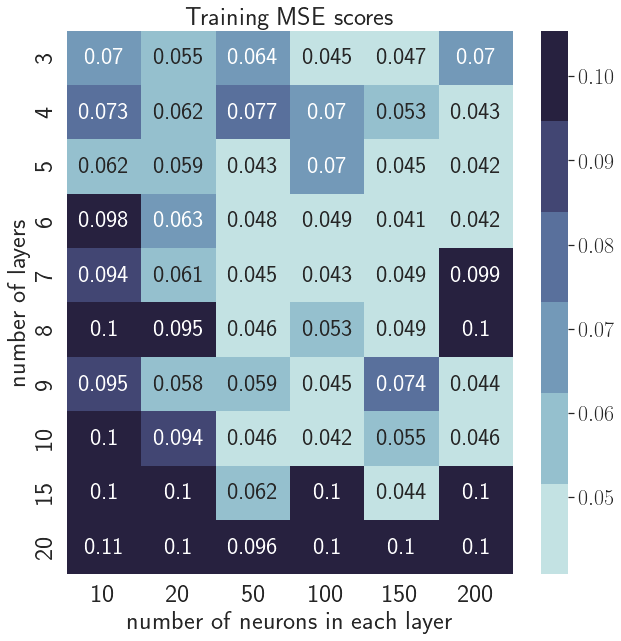

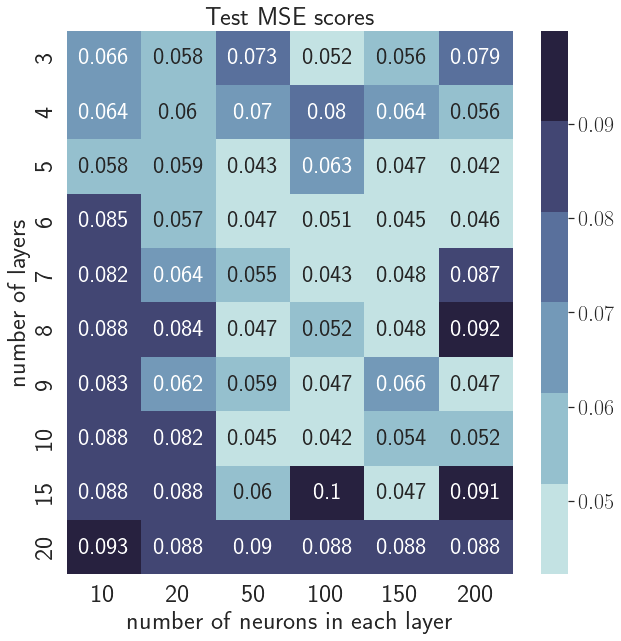

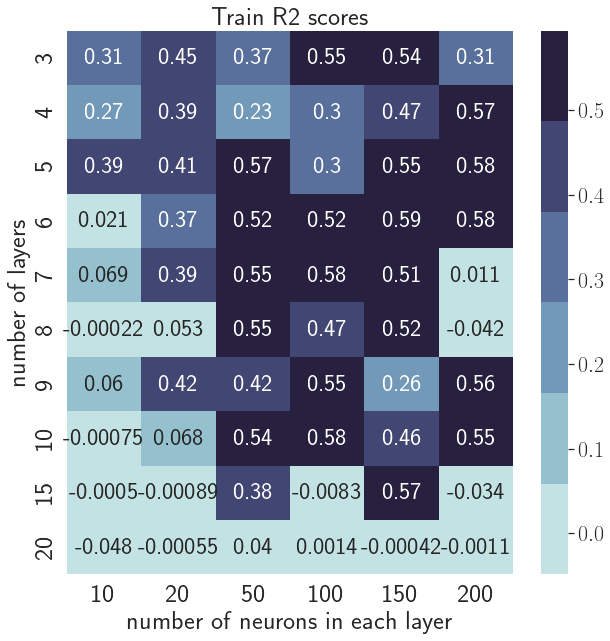

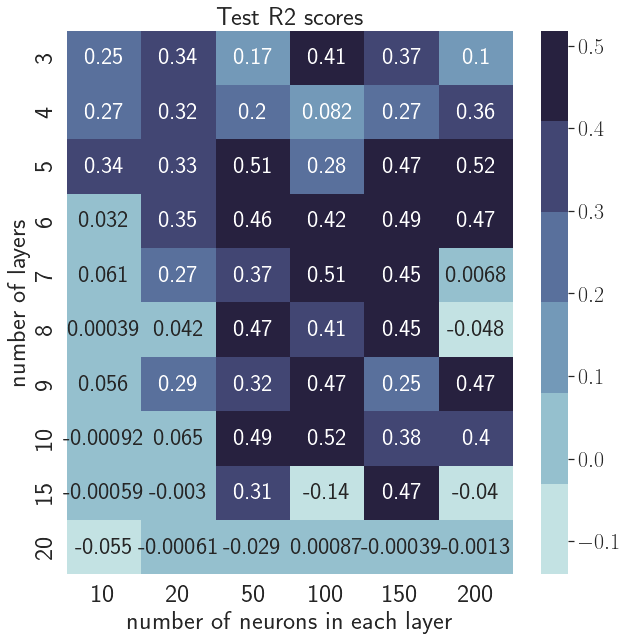

In [46]:
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
import seaborn as sns
NORMAL = 26
sns.set(font_scale=2)

train_MSE = np.zeros((len(n_layers), len(n_neurons_vals)))
test_MSE = np.zeros((len(n_layers), len(n_neurons_vals)))

train_R2 = np.zeros((len(n_layers), len(n_neurons_vals)))
test_R2 = np.zeros((len(n_layers), len(n_neurons_vals)))

for i in range(len(n_layers)):
    for j in range(len(n_neurons_vals)):
        dnn = DNN_numpy[i][j]
        
        train_pred = dnn.predict(X_train) 
        test_pred = dnn.predict(X_test)

        train_MSE[i][j] = MSE(z_train, train_pred)
        test_MSE[i][j] = MSE(z_test, test_pred)
        
        train_R2[i][j] = R2(z_train, train_pred)
        test_R2[i][j] = R2(z_test, test_pred)


fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_MSE, annot=True, ax=ax, cmap=sns.color_palette("ch:start=.2,rot=-.3"), yticklabels=n_layers, xticklabels=n_neurons_vals)
ax.set_title("Training MSE scores", fontsize=NORMAL)
ax.set_ylabel("number of layers", fontsize=NORMAL)
ax.set_xlabel("number of neurons in each layer", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_MSE_score_layers_neurons.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_MSE, annot=True, ax=ax, cmap=sns.color_palette("ch:start=.2,rot=-.3"), yticklabels=n_layers, xticklabels=n_neurons_vals)
ax.set_title("Test MSE scores", fontsize=NORMAL)
ax.set_ylabel("number of layers", fontsize=NORMAL)
ax.set_xlabel("number of neurons in each layer", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_MSE_score_layers_neurons.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_R2, annot=True, ax=ax, cmap=sns.color_palette("ch:start=.2,rot=-.3"), yticklabels=n_layers, xticklabels=n_neurons_vals)
ax.set_title("Train R2 scores", fontsize=NORMAL)
ax.set_ylabel("number of layers", fontsize=NORMAL)
ax.set_xlabel("number of neurons in each layer", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_R2_score_layers_neurons.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_R2, annot=True, ax=ax, cmap=sns.color_palette("ch:start=.2,rot=-.3"), yticklabels=n_layers, xticklabels=n_neurons_vals)
ax.set_title("Test R2 scores", fontsize=NORMAL)
ax.set_ylabel("number of layers", fontsize=NORMAL)
ax.set_xlabel("number of neurons in each layer", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_R2_score_layers_neurons.pdf", format="pdf")
plt.show()

### epoch and batch size grid search

In [55]:
np.random.seed(0)

epoch_vals = [1, 2, 5, 10, 20, 50, 100]
b_s_vals = [1, 2, 5, 10, 20, 50, 100]
# store the models for later use
DNN_numpy = np.zeros((len(epoch_vals), len(b_s_vals)), dtype=object)
for i, epoch in enumerate(epoch_vals):
    for j, b_s in enumerate(b_s_vals):
        dnn = NN(X_train, 
                 z_train,n_neurons=[100, 100, 100, 100, 100, 100, 100], 
                 epochs=epoch, 
                 batch_size=b_s, 
                 eta=0.01, 
                 lmbd=0.0001, 
                 n_categories=1, 
                 hidden_act_function="sigmoid", 
                 gamma = 0.2, 
                 last_act_function="return input", 
                 model="Regressor")
        dnn.train()
        
        DNN_numpy[i][j] = dnn
        
        test_predict = dnn.predict(X_test)
        train_predict = dnn.predict(X_train)
        
        print("Shape of test_predict: ", (test_predict.shape))
        print("Shape of train_predict: ", (train_predict.shape))
        
        print("number of epochs  = ", epoch)
        print("batch size = ", b_s)
        print("MSE train: ", MSE(train_predict, z_train))
        print("R2 train: ", R2(train_predict, z_train))
        print("MSE test: ", MSE(test_predict, z_test))
        print("R2 test: ", R2(test_predict, z_test))
        #print("Accuracy score on test set: ", accuracy_score(y_test, test_predict))
        #print("Accuracy score on train set: ", accuracy_score(y_train, train_predict))
        print()

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
number of epochs  =  1
batch size =  1
MSE train:  0.054790981908912406
R2 train:  0.23880355368592832
MSE test:  0.05959192596450611
R2 test:  0.18507936884223142

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
number of epochs  =  1
batch size =  2
MSE train:  0.05445226409213214
R2 train:  0.09820924137864606
MSE test:  0.05621610484647007
R2 test:  0.13680203005363167

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
number of epochs  =  1
batch size =  5
MSE train:  0.056600864093405

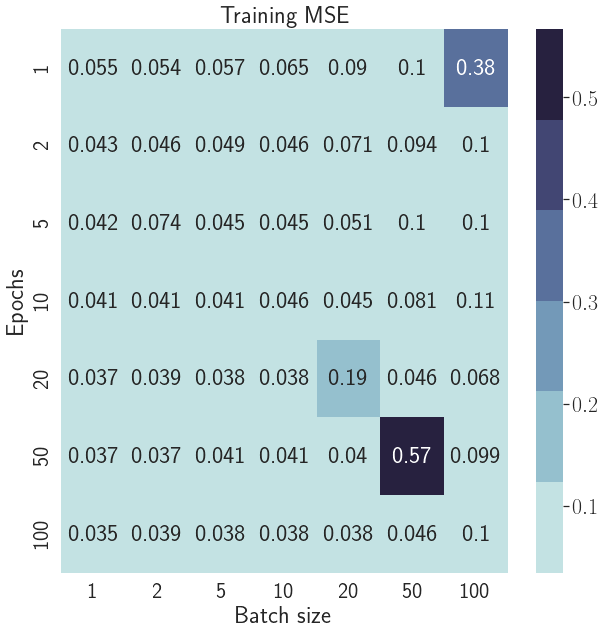

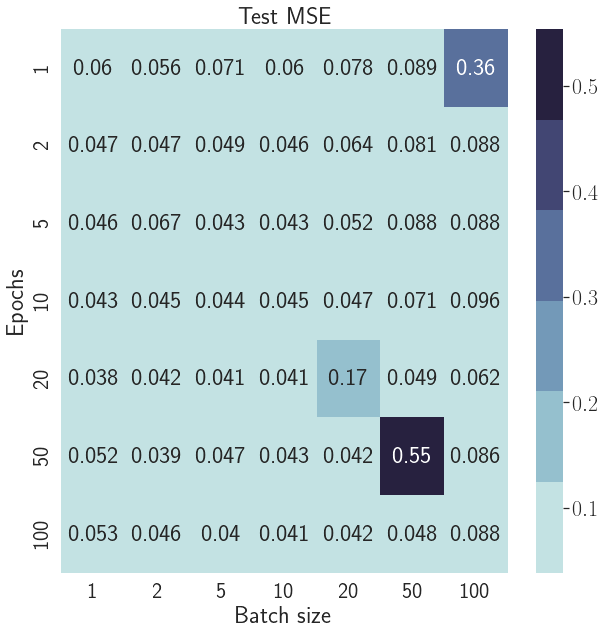

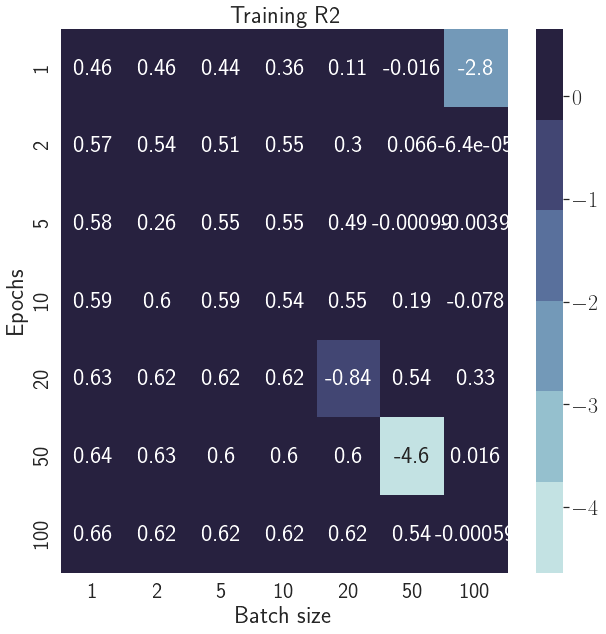

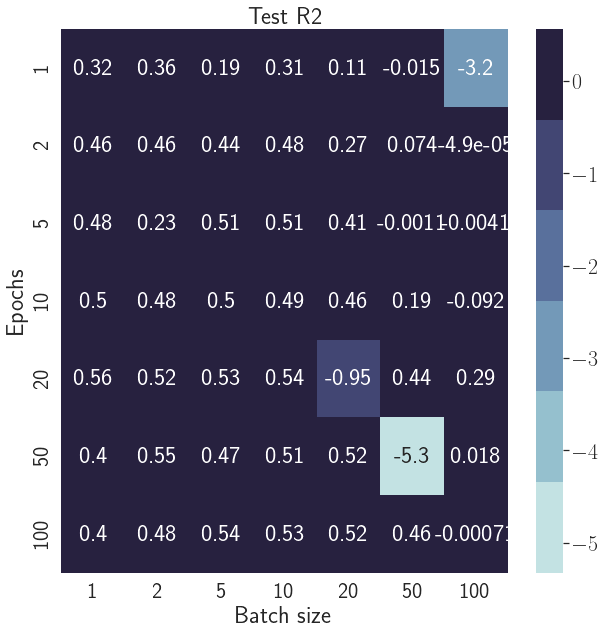

In [56]:
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
import seaborn as sns
NORMAL = 26
sns.set(font_scale=2)

train_MSE = np.zeros((len(epoch_vals), len(b_s_vals)))
test_MSE = np.zeros((len(epoch_vals), len(b_s_vals)))

train_R2 = np.zeros((len(epoch_vals), len(b_s_vals)))
test_R2 = np.zeros((len(epoch_vals), len(b_s_vals)))

for i in range(len(epoch_vals)):
    for j in range(len(b_s_vals)):
        dnn = DNN_numpy[i][j]
        
        train_pred = dnn.predict(X_train) 
        test_pred = dnn.predict(X_test)
        
        train_MSE[i][j] = MSE(z_train, train_pred)
        test_MSE[i][j] = MSE(z_test, test_pred)
        
        train_R2[i][j] = R2(z_train, train_pred)
        test_R2[i][j] = R2(z_test, test_pred)



    


fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_MSE, annot=True, ax=ax, cmap=sns.color_palette("ch:start=.2,rot=-.3"), yticklabels=epoch_vals, xticklabels=b_s_vals)
ax.set_title("Training MSE")
ax.set_ylabel("Epochs")
ax.set_xlabel("Batch size")
#ax.set_yticks([-5, -4, -3, -2, -1, 0, 1])
#ax.set_xticks([-5, -4, -3, -2, -1, 0, 1])
plt.savefig("train_MSE_score_epoch_bs.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_MSE, annot=True, ax=ax, cmap=sns.color_palette("ch:start=.2,rot=-.3"),yticklabels=epoch_vals, xticklabels=b_s_vals )
ax.set_title("Test MSE")
ax.set_ylabel("Epochs")
ax.set_xlabel("Batch size")
#ax.set_yticks([-5, -4, -3, -2, -1, 0, 1])
#ax.set_xticks([-5, -4, -3, -2, -1, 0, 1])
plt.savefig("test_MSE_score_epoch_bs.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_R2, annot=True, ax=ax, cmap=sns.color_palette("ch:start=.2,rot=-.3"), yticklabels=epoch_vals, xticklabels=b_s_vals)
ax.set_title("Training R2")
ax.set_ylabel("Epochs")
ax.set_xlabel("Batch size")
#ax.set_yticks([-5, -4, -3, -2, -1, 0, 1])
#ax.set_xticks([-5, -4, -3, -2, -1, 0, 1])
plt.savefig("train_R2_score_epoch_bs.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_R2, annot=True, ax=ax, cmap=sns.color_palette("ch:start=.2,rot=-.3"), yticklabels=epoch_vals, xticklabels=b_s_vals)
ax.set_title("Test R2")
ax.set_ylabel("Epochs")
ax.set_xlabel("Batch size")
#ax.set_yticks([-5, -4, -3, -2, -1, 0, 1])
#ax.set_xticks([-5, -4, -3, -2, -1, 0, 1])
plt.savefig("test_R2_score_epoch_bs.pdf", format="pdf")
plt.show()

### gamma value search

In [74]:
np.random.seed(0)
gamma_val = np.arange(0,1,1/10)
DNN_numpy = np.zeros(np.shape(gamma_val)[0])
for gamma in gamma_val:
    dnn = NN(X_train, 
                 z_train,n_neurons=[100, 100, 100, 100, 100, 100, 100], 
                 epochs=20, 
                 batch_size=10, 
                 eta=0.01, 
                 lmbd=0.0001, 
                 n_categories=1, 
                 hidden_act_function="sigmoid", 
                 gamma = gamma, 
                 last_act_function="return input", 
                 model="Regressor")
    dnn.train()
    #DNN_numpy[i] = dnn
    test_predict = dnn.predict(X_test)
    train_predict = dnn.predict(X_train)

    print("Shape of test_predict: ", (test_predict.shape))
    print("Shape of train_predict: ", (train_predict.shape))

    print("gamma = ", gamma)
    print("MSE train: ", MSE(train_predict, z_train))
    print("R2 train: ", R2(train_predict, z_train))
    print("MSE test: ", MSE(test_predict, z_test))
    print("R2 test: ", R2(test_predict, z_test))
    #print("Accuracy score on test set: ", accuracy_score(y_test, test_predict))
    #print("Accuracy score on train set: ", accuracy_score(y_train, train_predict))
    print()

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)


<ipython-input-2-854ace93e973>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-2-854ace93e973>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
gamma =  0.0
MSE train:  0.1298223766066538
R2 train:  -1.3096747269729128e+21
MSE test:  0.1169074279793478
R2 test:  -1.277134928184109e+21

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
gamma =  0.1
MSE train:  0.038963118288546414
R2 train:  0.3792247720458297
MSE test:  0.04345082635528803
R2 test:  0.14809287367380553

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data shape:  (1280, 231)
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
gamma =  0.2
MSE train:  0.03994135594898361
R2 train:  0.24946613479661972
MSE test:  0.04126829542738688
R2 test:  0.1929779848571923

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
X_data